In [4]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import college_admissions_experiments as script
import ipdb
import pandas as pd
import tqdm.notebook as tqdm
from multiprocessing import Pool
import seaborn as sns


In [5]:
def run_multi_exp(seed, args, env_idx=None):
    np.random.seed(seed)
    b, x, y, EW, theta, w, z, y_hat, adv_idx, disadv_idx, o, theta_star, pref_vect  = script.generate_data(
    args.num_applicants, args.admit_all, args.applicants_per_round, args.fixed_effort_conversion, args
    )

    err_list = {}
    envs_itr = [env_idx] if env_idx is not None else range(args.num_envs)
    for env_idx in envs_itr:
        dictenv = run_single_env(args, x, y, theta, z, theta_star, env_idx)
        for k, v in dictenv.items():
            err_list[f'{k}_env{env_idx}'] = v
    
    return err_list

def run_single_env(args, x, y, theta, z, theta_star, env_idx):
    y_env = y[env_idx].flatten() 
    theta_env = theta[env_idx]
    z_env = z==env_idx+1
        
    upp_limits = [x for x in range(args.applicants_per_round*2, args.num_applicants+1, args.applicants_per_round)]
        
    err_list = {m: [None] * len(upp_limits) for m in args.methods}
    for i, t in tqdm.tqdm(enumerate(upp_limits)):
        x_round = x[:t]
        y_env_round = y_env[:t]
        z_env_round = z_env[:t]
        theta_env_round = theta_env[:t]

        # filtering out rejected students
        y_env_round_selected = y_env_round[z_env_round]
        x_round_selected = x_round[z_env_round]
        theta_env_round_selected = theta_env_round[z_env_round]

        for m in args.methods:
            if m == 'ours':
                est = script.our2(x_round, y_env_round_selected, theta_env_round, z_env_round)
            elif m == '2sls':
                try:
                    est = script.tsls(x_round_selected, y_env_round_selected, theta_env_round_selected)
                except np.linalg.LinAlgError:
                    est = np.array([np.nan, np.nan])
            elif m == 'ols':
                est = script.ols(x_round_selected, y_env_round_selected)
            
            assert theta_star[env_idx].shape == est.shape, f"{theta[0].shape}, {est.shape}"
            err_list[m][i] = np.linalg.norm(theta_star[env_idx] - est )
    return err_list

# convert to dataframe.
def runs2df(runs):
    """
    Args:
    runs: List of dictionaries

    Returns:
    Converts to list of dataframes and concatenate those together.
    """
    dfs = []
    for r in runs:
        df = pd.DataFrame(r)
        dfs.append(df)
    df = pd.concat(dfs)
    df.reset_index(inplace=True); df.rename({'index': 'iterations'}, axis=1, inplace=True)
    return df

In [83]:
n_runs = 10
cmd =f'--num-applicants 300000 --applicants-per-round 1000 --clip --methods ols 2sls --stream'
args = script.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(run_multi_exp, args_list )
runs

[{'ols_env0': [0.7833964357062004,
   0.08262352077893059,
   0.12086068269255376,
   0.1507867215802302,
   0.09853788523176613,
   0.11397576015852284,
   0.1249538342792047,
   0.08099054970614225,
   0.0697318526059615,
   0.05969392870071355,
   0.07303641703720294,
   0.07625835935908894,
   0.08255639018774778,
   0.09593520211349386,
   0.10420421082623546,
   0.11279498153083926,
   0.1183198500306262,
   0.12376846052384254,
   0.11662926618776509,
   0.11862463086246541,
   0.12238329375350107,
   0.12517297979558772,
   0.13238944484764056,
   0.13686443897698947,
   0.13241422996546567,
   0.13636632003013124,
   0.10438361176674682,
   0.09559609469975393,
   0.09890630678588946,
   0.09886989787119323,
   0.10028690718238954,
   0.10219969904427303,
   0.10446153695647355,
   0.09926967166791059,
   0.10149530656784807,
   0.10471471196254518,
   0.10621671960288516,
   0.10768926484851996,
   0.1062345677399382,
   0.1087641862994933,
   0.10744677504950702,
   0.108068

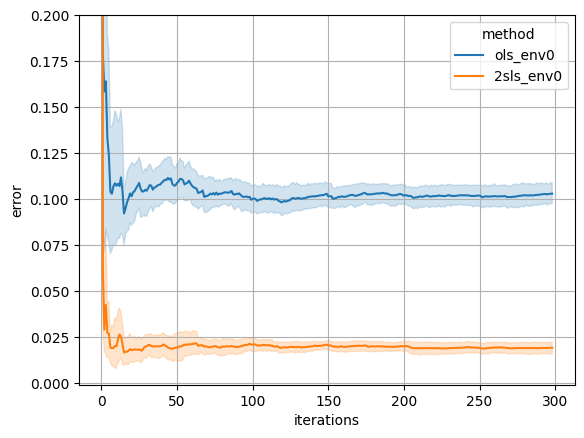

In [84]:
df = runs2df(runs)
dflong = pd.melt(df, id_vars='iterations', value_vars=('ols_env0', '2sls_env0'), var_name='method', value_name='error')
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', ax=ax)
ax.set_ylim(bottom=-0.001, top=0.2)
ax.set_ylabel(r'$|| \theta^* - \hat{hat}|| $')
ax.set_xlabel('number of rounds')
ax.grid()

In [ ]:
n_runs = 10
cmd =f'--num-applicants 300000 --applicants-per-round 1000 --fixed-effort-conversion --scaled-duplicates sequence --b-bias 2 --num-envs 1 --pref uniform --methods ours 2sls ols'
args = script.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(run_multi_exp, args_list )

In [54]:
# convert to dataframe.
# dfs = []
# for r in runs:
    # df = pd.DataFrame(r)
    # dfs.append(df)
# df = pd.concat(dfs)
# df.reset_index(inplace=True); df.rename({'index': 'iterations'}, axis=1, inplace=True)
# df
df = runs2df(runs)

,iterations,ours_env0,2sls_env0,ols_env0
0,0,NaN,0.003213,0.122624
1,1,NaN,0.007674,0.159563
2,2,0.852264,0.012840,0.159797
3,3,0.852264,0.007328,0.133577
4,4,0.005747,0.006685,0.132621
...,...,...,...,...
2985,294,0.000358,0.059321,0.170173
2986,295,0.000224,0.059355,0.170427
2987,296,0.000327,0.059282,0.170651
2988,297,0.000188,0.059333,0.170809


In [55]:
# long format for plotting
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong['method'] = dflong.env.apply(lambda x: x.split('_')[0])
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong

,iterations,env,error,method
0,0,env0,NaN,ours
1,1,env0,NaN,ours
2,2,env0,0.852264,ours
3,3,env0,0.852264,ours
4,4,env0,0.005747,ours
...,...,...,...,...
8965,294,env0,0.170173,ols
8966,295,env0,0.170427,ols
8967,296,env0,0.170651,ols
8968,297,env0,0.170809,ols


(-0.001, 0.2)

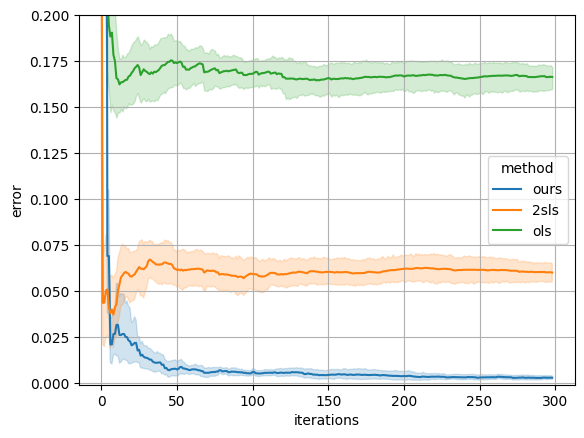

In [58]:
# dflong = pd.melt(df, id_vars='iterations', value_vars=('ours_env0', 'ours_env1'), var_name='env', value_name='error')
fig,ax=plt.subplots()
sns.lineplot(dflong, x='iterations', y='error', errorbar=('ci', 95), ax=ax, hue='method')
ax.grid()
ax.set_ylim(bottom=-0.001, top=.2)
ax.set_ylabel(r'$|| \theta^* - \hat{hat}|| $')
ax.set_xlabel('number of rounds')

In [4]:
n_runs = 10
cmd =f'--num-applicants 300000 --applicants-per-round 1000 --fixed-effort-conversion --scaled-duplicates sequence --b-bias 2 --num-envs 2 --pref uniform --methods ours 2sls ols'
args = script.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(run_multi_exp, args_list )

In [9]:
df = runs2df(runs)
df
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong['method'] = dflong.env.apply(lambda x: x.split('_')[0])
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong

,iterations,env,error,method
0,0,env0,NaN,ours
1,1,env0,NaN,ours
2,2,env0,0.852759,ours
3,3,env0,0.852759,ours
4,4,env0,0.587694,ours
...,...,...,...,...
17935,294,env1,0.220274,ols
17936,295,env1,0.220567,ols
17937,296,env1,0.220583,ols
17938,297,env1,0.220411,ols


Text(0.5, 0, 'number of rounds')

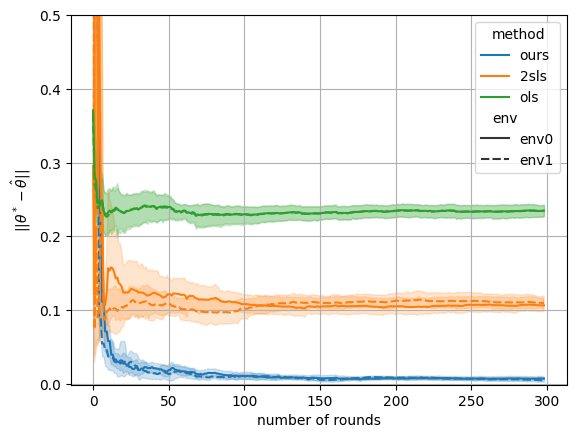

In [15]:
fig,ax=plt.subplots()
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', style='env', errorbar=('ci', 95), ax=ax)
ax.grid()
ax.set_ylim(bottom=-.001, top=.5)
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')

In [16]:
_runs = []
for protocol in (True, False):
    cmd = f'--num-applicants 300000 --applicants-per-round 1000 --fixed-effort-conversion --scaled-duplicates sequence --b-bias 2 --num-envs 2 --pref uniform --methods ours'
    if not protocol:
        cmd = f'{cmd} --no-protocol'
    print(cmd)
    
    args = script.get_args(cmd)
    n_runs = 10
    args_list = [(s, args, 0) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(run_multi_exp, args_list )
        _runs.append(runs)

--num-applicants 300000 --applicants-per-round 1000 --fixed-effort-conversion --scaled-duplicates sequence --b-bias 2 --num-envs 2 --pref uniform --methods ours
--num-applicants 300000 --applicants-per-round 1000 --fixed-effort-conversion --scaled-duplicates sequence --b-bias 2 --num-envs 2 --pref uniform --methods ours --no-protocol


In [23]:
df0 = runs2df(_runs[0])
df1 = runs2df(_runs[1])
df0['is-protocol'] = True
df1['is-protocol'] = False
df = pd.concat((df0, df1))
df

,iterations,ours_env0,is-protocol
0,0,NaN,True
1,1,NaN,True
2,2,0.852759,True
3,3,0.852759,True
4,4,0.587694,True
...,...,...,...
2985,294,0.041248,False
2986,295,0.041297,False
2987,296,0.041592,False
2988,297,0.041619,False


Text(0, 0.5, '$ || \\theta^* - \\hat{\\theta}|| $')

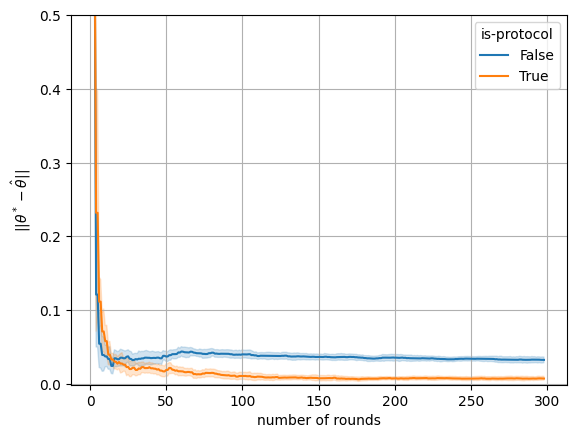

In [27]:
fig,ax=plt.subplots()
sns.lineplot(data=df.reset_index(), x='iterations', y='ours_env0', hue='is-protocol')
ax.grid()
ax.set_ylim(bottom=-.001, top=.5)
ax.set_xlabel('number of rounds')
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')